# Warping playground
In Millican _et al._ (2025), Sec. III posits two techniques for handling underlying nonstationarity with a GP model: warping and a nonstationary kernel (NSK).
The purpose of this notebook is to develop techniques in those domains and experiment with them to improve the BUQEYE model and its limitations.

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *
from scripts.generator_fns import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn, griddata
import gsum
import functools 

from shapely.geometry import Polygon, Point

%matplotlib inline

In [2]:
def create_pairs(arr1, arr2):
    m, n = arr1.shape[0], arr2.shape[-1]
    pairs = np.empty((m, n, 2))
    for i in range(m):
        for j in range(n):
            pairs[i, j, 0] = arr1[i]  # Assign the first array to the first dimension of the pairs
            try:
                pairs[i, j, 1] = arr2[i, j]  # Assign the second array to the second dimension of the pairs
            except:
                pairs[i, j, 1] = arr2[j]
    return pairs

## Part 1: Nonstationarity in real data
This part of the notebook handles real data from any potential of the sixteen under test in Millican _et al._ (2025).

In [3]:
# warping function that operates on a 2D array
def warping_fn(pts_array):
    pts_array_shape = np.shape(pts_array)
    pts_array = np.reshape(pts_array, (np.prod(pts_array_shape[:-1]), ) + (pts_array_shape[-1], ))
    try:
        for pt_idx, pt in enumerate(pts_array):
            pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0],
                                             pts_array[pt_idx, 1]])
#         # SMS 550 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.28 / (136 * (pts_array[pt_idx, 0])**(-1.04)),])
        # SMS 500 MeV
        for pt_idx, pt in enumerate(pts_array):
            pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
                    pts_array[pt_idx, 1] * pts_array[pt_idx, 0]**(0.99) / 405,])
#         # SMS 450 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (38 * (pts_array[pt_idx, 0])**(-0.80)),])
#         # SCS 0.9 fm
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (120 * (pts_array[pt_idx, 0])**(-1.0)),])
#         # EMN 500 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.37 / (20 * (pts_array[pt_idx, 0])**(-0.66)),])
    except:
        pass

    pts_array = np.reshape(pts_array, pts_array_shape)

    return pts_array

# reverse-warping function
def reverse_warping_fn(pts_array):
    pts_array_shape = np.shape(pts_array)
    pts_array = np.reshape(pts_array, (np.prod(pts_array_shape[:-1]), ) + (pts_array_shape[-1], ))
    try:
        for pt_idx, pt in enumerate(pts_array):
            pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0],
                                             pts_array[pt_idx, 1]])
#         # SMS 550 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.28 / (136 * (pts_array[pt_idx, 0])**(-1.04)),])
#         # SMS 500 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] / 0.28 * (110 * (pts_array[pt_idx, 0])**(-0.99)),])
#         # SMS 450 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (38 * (pts_array[pt_idx, 0])**(-0.80)),])
#         # SCS 0.9 fm
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.30 / (120 * (pts_array[pt_idx, 0])**(-1.0)),])
#         # EMN 500 MeV
#         for pt_idx, pt in enumerate(pts_array):
#             pts_array[pt_idx, :] = np.array([pts_array[pt_idx, 0], 
#                     pts_array[pt_idx, 1] * 0.37 / (20 * (pts_array[pt_idx, 0])**(-0.66)),])
    except:
        pass

    pts_array = np.reshape(pts_array, pts_array_shape)

    return pts_array

# length-scale scaling function (for NSK approach)
def scaling_fn(X,
               ls_array = np.array([1]),
               exponent = 0, 
               magnitude = 1):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    ls = np.array([])
        
    for pt_idx, pt in enumerate(X):
        ls = np.append(ls, np.array([ls_array[0], ls_array[1]]))
#         ls = np.append(ls, np.array([ls_array[0], ls_array[1] * X[pt_idx, 0]**(-1. * exponent)
#                                      ]))
#         ls = np.append(ls, np.array([100, magnitude * X[pt_idx, 0]**(-1. * exponent)
#                                      ]))

    ls = np.reshape(ls, X_shape)

    return ls

scaling_fn_kwargs={"exponent" : 0.99, "magnitude" : 110}

# cbar^2 (i.e., variance) scaling function
def cbar_fn(X,
               cbar_array = np.array([1]),
               scaling = 1,
               offset = 0.5):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    cbar = np.array([])

    for pt_idx, pt in enumerate(X):
#         R = np.max(X[:, 0]) - np.min(X[:, 0])
        cbar = np.append(cbar, cbar_array)
#         cbar = np.append(cbar, np.array([(1 + (scaling / R * (pt[0] - offset * R)) ** (2)) ** (-0.5)
#                                          ]))
    cbar = np.reshape(cbar, X_shape[:-1])
    
    return cbar

cbar_fn_kwargs={"scaling" : 1.7,
                "offset" : 0.71}

In [4]:
class GSUMsandbox:
    def __init__(self, schemescale, 
                observable, 
                inputspace, 
                traintestsplit,
                gphyperparameters, 
                orderinfo, 
                filenaming,
                x_quantity=[None, None, None], 
                warping_fn = None,
                warping_fn_kwargs = None, 
                
                length_scale_list=None,
                length_scale_fixed=False,
                cbar_list=None,
                cbar_fixed=False,
                scaling_fn = None,
                scaling_fn_kwargs = None,
                cbar_fn = None,
                cbar_fn_kwargs = None):
        """
        Class for everything involving Jordan Melendez's GSUM library for observables that
        can be plotted against angle.

        Parameters
        ----------
        nn_interaction (str) : two-letter string for two nucleons interacting in observables.
        observable (ObservableBunch) : observable being plotted.
        inputspace (InputSpaceBunch) : input space against which the observable is plotted.
        traintestsplit (TrainTestSplit) : training and testing masks.
        gphyperparameters (GPHyperparameters) : parameters for fitted Gaussian process.
        orderinfo (OrderInfo) : information about the EFT orders and their colors.
        filenaming (FileNaming) : strings for naming the save files.
        fixed_quantity (list) : [fixed_quantity name (str), fixed_quantity value (float), fixed_quantity array (array), fixed_quantity units (str)]
        x_quantity (list) : [x_quantity name (str), x_quantity array (array), x_quantity units (str)]
        """
        self.schemescale = schemescale
        self.scheme = self.schemescale.potential_string
        self.scale = self.schemescale.cutoff_string

        # information on the observable
        self.observable = observable
        self.observable_name = self.observable.name
        self.observable_label = self.observable.title
        self.data_raw = self.observable.data
        self.data = self.observable.data
        self.ref_type = self.observable.ref_type
        self.nn_interaction = self.observable.nn_interaction
        self.observable_units = self.observable.unit_string
        self.constraint = self.observable.constraint

#         # energy or angle at which the observable is evaluated, along with all
#         # possible energies or angles for evaluation
#         self.fixed_quantity_name = []
#         self.fixed_quantity_value = []
#         self.fixed_quantity_array = []
#         self.fixed_quantity_units = []
#         for fq in fixed_quantity:
#             self.fixed_quantity_name.append(fq[0])
#             self.fixed_quantity_value.append(fq[1])
#             self.fixed_quantity_array.append(fq[2])
#             self.fixed_quantity_units.append(fq[3])

        # angle or energy mesh
        self.x_quantity_name = []
        self.x_quantity_array = []
        self.x_quantity_full = []
        self.x_quantity_units = []
        for xq in x_quantity:
            self.x_quantity_name.append(xq[0])
            self.x_quantity_array.append(xq[1])
            self.x_quantity_full.append(xq[2])
            self.x_quantity_units.append(xq[3])
            
        self.x_quantity_num = 0
        for xq in self.x_quantity_array:
            if np.shape(xq)[0] != 1: self.x_quantity_num += 1;

        # information on the input space
        self.vs_what = np.array([])
        self.x = np.array([])
        self.X = np.array([])
        self.caption_coeffs = np.array([])
        self.title_coeffs = np.array([])
        for isp_idx, isp in enumerate(inputspace):
            self.vs_what = np.append(self.vs_what, isp.name)
            self.caption_coeffs = np.append(self.caption_coeffs, isp.caption)
            self.title_coeffs = np.append(self.title_coeffs, isp.title)
#         self.x = np.array(list(itertools.product(tuple(
#                     [isp.input_space(**{"deg_input": self.x_quantity_array[1],
#                                         "p_input": E_to_p(self.x_quantity_array[0],
#                                                           interaction=self.nn_interaction),
#                                         "E_lab": self.x_quantity_array[0],
#                                         "interaction": self.nn_interaction}) for isp in inputspace])
#                               )))
        if len(inputspace) == 1:
            try:
                self.x_full = gm.cartesian(*[isp.input_space(**{"deg_input": self.x_quantity_full[1],
                                                                  "p_input": E_to_p(self.x_quantity_full[0],
                                                                                    interaction=self.nn_interaction),
                                                                  "E_lab": self.x_quantity_full[0],
                                                                  "interaction": self.nn_interaction}) for isp in
                                               inputspace])
                self.x = gm.cartesian(*[isp.input_space(**{"deg_input": self.x_quantity_array[1],
                                                             "p_input": E_to_p(self.x_quantity_array[0],
                                                                               interaction=self.nn_interaction),
                                                             "E_lab": self.x_quantity_array[0],
                                                             "interaction": self.nn_interaction}) for isp in
                                          inputspace])
            except:
                self.x_full = gm.cartesian(*[isp.input_space(**{
                    "p_input": E_to_p(self.x_quantity_full[0],
                                      interaction=self.nn_interaction),
                    "E_lab": self.x_quantity_full[0],
                    "interaction": self.nn_interaction}) for isp in inputspace])
                self.x = gm.cartesian(*[isp.input_space(**{
                    "p_input": E_to_p(self.x_quantity_array[0],
                                      interaction=self.nn_interaction),
                    "E_lab": self.x_quantity_array[0],
                    "interaction": self.nn_interaction}) for isp in inputspace])
        elif len(inputspace) == 2:
            try:
                self.x_full = create_pairs(*[isp.input_space(**{"deg_input": self.x_quantity_full[1],
                                                                  "p_input": E_to_p(self.x_quantity_full[0],
                                                                                    interaction=self.nn_interaction),
                                                                  "E_lab": self.x_quantity_full[0],
                                                                  "interaction": self.nn_interaction}) for isp in
                                               inputspace])
                self.x = create_pairs(*[isp.input_space(**{"deg_input": self.x_quantity_array[1],
                                                             "p_input": E_to_p(self.x_quantity_array[0],
                                                                               interaction=self.nn_interaction),
                                                             "E_lab": self.x_quantity_array[0],
                                                             "interaction": self.nn_interaction}) for isp in
                                          inputspace])
            except:
                self.x_full = create_pairs(*[isp.input_space(**{
                    "p_input": E_to_p(self.x_quantity_full[0],
                                      interaction=self.nn_interaction),
                    "E_lab": self.x_quantity_full[0],
                    "interaction": self.nn_interaction}) for isp in inputspace])
                self.x = create_pairs(*[isp.input_space(**{
                    "p_input": E_to_p(self.x_quantity_array[0],
                                      interaction=self.nn_interaction),
                    "E_lab": self.x_quantity_array[0],
                    "interaction": self.nn_interaction}) for isp in inputspace])
                
                
        self.X = self.x[..., None]
#         print("self.X has shape " + str(np.shape(self.X)))
        
#         print(tuple((np.shape(xq) for xq in self.x_quantity_array)))
#         print((len(self.x_quantity_array)))
        self.x_full = np.reshape(self.x_full, 
                           tuple(len(xq) for xq in self.x_quantity_array if len(xq) > 1) + \
                           (self.x_quantity_num, ))
        self.x = np.reshape(self.x, 
                           tuple(len(xq) for xq in self.x_quantity_array if len(xq) > 1) + \
                           (self.x_quantity_num, ))
#         print("self.x has shape " + str(np.shape(self.x)))
#         print("self.x = " + str(self.x))
        self.X = np.reshape(self.X, 
                           tuple(len(xq) for xq in self.x_quantity_array if len(xq) > 1) + \
                           (self.x_quantity_num, ) + (1, ))
#         print("self.X has shape " + str(np.shape(self.X)))

#         information on the train/test split
        self.traintestsplit = traintestsplit
#         self.train_pts_loc = self.traintestsplit.name
#         self.x_train = self.traintestsplit.x_train
#         self.n_train_pts = len(self.x_train)
#         self.x_test = self.traintestsplit.x_test
#         self.n_test_pts = len(self.x_test)
#         self.y_train = self.traintestsplit.y_train
#         self.y_test = self.traintestsplit.y_test

        # data
#         print("self.data has shape " + str(np.shape(self.data)))
        mymask = functools.reduce(np.multiply, 
                        np.ix_(*[np.isin(xqfull, xqval).astype(int) for (xqfull, xqval) in 
                                 zip(self.x_quantity_full, self.x_quantity_array)]))
#         print("mymask has shape " + str(np.shape(mymask)))
        mymask_tiled = np.tile(mymask, (np.shape(self.data)[0], ) + 
                         (1, ) * (self.data.ndim - 1)
                        )
#         print("mymask_tiled has shape " + str(np.shape(mymask_tiled)))
        self.data = self.data[mymask_tiled.astype(bool)]
#         print("self.data has shape " + str(np.shape(self.data)))
        self.data = np.reshape(self.data, (np.shape(mymask_tiled)[0], ) + 
                        tuple([len(arr) for arr in self.x_quantity_array if len(arr) > 1]))
#         print("self.data has shape " + str(np.shape(self.data)))
        
#         self.train_pts_loc = self.traintestsplit.name
#         self.traintestsplit.make_masks(self.x, self.data)
#         self.x_train = self.traintestsplit.x_train
#         self.X_train = self.x_train
#         self.n_train_pts = np.shape(self.x_train)[0]
#         self.x_test = self.traintestsplit.x_test
#         self.X_test = self.x_test
#         self.n_test_pts = np.shape(self.x_test)[0]
#         self.y_train = self.traintestsplit.y_train
# #         print("self.y_train before warping = " + str(self.y_train))
#         self.y_test = self.traintestsplit.y_test
# #         print("self.y_test before warping = " + str(self.y_test))
        
        if warping_fn is None:
            pass
        else:
            self.x = warping_fn(self.x, **warping_fn_kwargs)
            
#             # this should be commented out if the following block is uncommented, and vice-versa
#             self.x_train = warping_fn(self.traintestsplit.x_train, **warping_fn_kwargs)
#             print("self.x_train = " + str(self.x_train))
#             self.X_train = self.x_train
#             self.x_test = warping_fn(self.traintestsplit.x_test, **warping_fn_kwargs)
#             print("self.x_test = " + str(self.x_test))
#             self.X_test = self.x_test
        
        # KEEP THIS
        self.train_pts_loc = self.traintestsplit.name
        self.traintestsplit.make_masks(self.x, self.data)
        interp_method = 'linear'
        self.x_train = self.traintestsplit.x_train
        self.X_train = self.x_train
        self.n_train_pts = np.shape(self.x_train)[0]
        self.x_test = self.traintestsplit.x_test
        self.X_test = self.x_test
        self.n_test_pts = np.shape(self.x_test)[0]
        self.y_train = self.traintestsplit.y_train
        self.y_test = self.traintestsplit.y_test
        
#         # KEEP THIS
#         self.train_pts_loc = self.traintestsplit.name
#         self.traintestsplit.make_masks(self.x, self.data, 
#               warp_bool = True,
#               x_unwarped = np.reshape(self.x_full, 
#                    tuple(len(xq) for xq in self.x_quantity_array if len(xq) > 1) + \
#                    (self.x_quantity_num, )), 
#               warping_fn = warping_fn,
#               warping_fn_kwargs = warping_fn_kwargs
#             )
#         interp_method = 'nearest'
#         self.x_train = self.traintestsplit.x_train
#         self.X_train = self.x_train
#         self.n_train_pts = np.shape(self.x_train)[0]
#         self.x_test = self.traintestsplit.x_test
#         self.X_test = self.x_test
#         self.n_test_pts = np.shape(self.x_test)[0]
#         self.y_train = self.traintestsplit.y_train
#         self.y_test = self.traintestsplit.y_test

        
#         # KEEP THIS
#         self.train_pts_loc = self.traintestsplit.name
#         self.traintestsplit.make_masks(self.x, self.data, 
#               warp_bool = False,
#               x_unwarped = np.reshape(self.x_full, 
#                    tuple(len(xq) for xq in self.x_quantity_array if len(xq) > 1) + \
#                    (self.x_quantity_num, )), )
#         interp_method = 'nearest'
#         self.x_train = reverse_warping_fn(self.traintestsplit.x_train)
#         self.X_train = self.x_train
#         self.n_train_pts = np.shape(self.x_train)[0]
#         self.x_test = reverse_warping_fn(self.traintestsplit.x_test)
#         self.X_test = self.x_test
#         self.n_test_pts = np.shape(self.x_test)[0]
#         self.y_train = self.traintestsplit.y_train
#         self.y_test = self.traintestsplit.y_test
#         self.x = self.x_full

#         # for Jordan
#         self.x = np.reshape(self.x_full, np.shape(self.x))
        
#         fig_trash, ax_trash = plt.subplots()
#         x_trash, y_trash = np.concatenate([
#             self.x[0, :, ...], self.x[:, -1, ...], 
#             self.x[-1, :, ...], 
#             np.flip(self.x[:, 0, ...], axis = 0), 
#                         ]).T
#         ax_trash.plot(x_trash, y_trash)
        
#         print(self.x[0, :, ...])
#         print(self.x[:, -1, ...])
#         print(self.x[-1, :, ...])
#         print(self.x[:, 0, ...])
        
#         if np.shape(self.x)[-1] == 2:
#             warped_poly = Polygon(np.concatenate([
#                 self.x[0, :, ...], 
#                 self.x[:, -1, ...], 
#                 self.x[-1, :, ...], 
#                 np.flip(self.x[:, 0, ...], axis = 0), 
#                             ]))
#     #         print(warped_poly.contains((0, 0)))

#             print("self.x_train has shape " + str(np.shape(self.x_train)))
#             print("self.x_train = " + str(self.x_train))
#             self.x_train = self.x_train[[warped_poly.buffer(0.01).contains(Point(pt)) for pt in self.x_train], ...]
#             print("self.x_train has shape " + str(np.shape(self.x_train)))
#             print("self.x_train = " + str(self.x_train))

#             print("self.x_test has shape " + str(np.shape(self.x_test)))
#             print("self.x_test = " + str(self.x_test))
#             self.x_test = self.x_test[[warped_poly.buffer(0.01).contains(Point(pt)) for pt in self.x_test], ...]
#             print("self.x_test has shape " + str(np.shape(self.x_test)))
#             print("self.x_test = " + str(self.x_test))

#             self.y_train = np.array([])
#             self.y_test = np.array([])
#             for norder in self.data:
#                 self.y_train = np.append(self.y_train, griddata(
#                      np.reshape(self.x, (np.prod(np.shape(self.x)[0:-1]), ) + (np.shape(self.x)[-1], )),
#                      np.reshape(norder, np.prod(np.shape(norder))),
#                      self.x_train)
#                      )
#                 self.y_test = np.append(self.y_test, griddata(
#                     np.reshape(self.x, (np.prod(np.shape(self.x)[0:-1]),) + (np.shape(self.x)[-1],)),
#                     np.reshape(norder, np.prod(np.shape(norder))),
#                     self.x_test)
#                     )

#             self.y_train = np.reshape(self.y_train, (np.shape(self.data)[0], ) + (np.shape(self.x_train)[0], ))
#             self.y_test = np.reshape(self.y_test, (np.shape(self.data)[0], ) + (np.shape(self.x_test)[0], ))

#             print("self.y_train after warping = " + str(self.y_train))
#             print("self.y_test after warping = " + str(self.y_test))
#         elif np.shape(self.x)[-1] == 1:
#             self.x_train = self.x_train[[(pt >= np.min(self.x[:, 0]) and pt <= np.max(self.x[:, 0])) for pt in self.x_train], ...][:, None]
#             self.x_test = self.x_test[[(pt >= np.min(self.x[:, 0]) and pt <= np.max(self.x[:, 0])) for pt in self.x_test], ...][:, None]

#             self.y_train = np.array([])
#             self.y_test = np.array([])
#             for norder in self.data:
#                 self.y_train = np.append(self.y_train, griddata(
#                      np.reshape(self.x, (np.prod(np.shape(self.x)[0:-1]), ) + (np.shape(self.x)[-1], )),
#                      np.reshape(norder, np.prod(np.shape(norder))),
#                      self.x_train)
#                      )
#                 self.y_test = np.append(self.y_test, griddata(
#                     np.reshape(self.x, (np.prod(np.shape(self.x)[0:-1]),) + (np.shape(self.x)[-1],)),
#                     np.reshape(norder, np.prod(np.shape(norder))),
#                     self.x_test)
#                     )

#             self.y_train = np.reshape(self.y_train, (np.shape(self.data)[0], ) + (np.shape(self.x_train)[0], ))
#             self.y_test = np.reshape(self.y_test, (np.shape(self.data)[0], ) + (np.shape(self.x_test)[0], ))
#             print("self.y_train has shape " + str(np.shape(self.y_train)))
#             print("self.y_train = " + str(self.y_train))
            
        # information on the GP hyperparameters
        self.gphyperparameters = gphyperparameters
        self.ls_array = self.gphyperparameters.ls_array
        self.ls_lower = self.gphyperparameters.ls_lower_array
        self.ls_upper = self.gphyperparameters.ls_upper_array
#         for (lsv, lsl, lsu) in zip(gphyperparameters.ls, 
#                                    gphyperparameters.ls_lower, 
#                                    gphyperparameters.ls_upper):
#             self.ls.append(lsv)
#             self.ls_lower.append(lsl)
#             self.ls_upper.append(lsu)
        self.whether_fit_array = self.gphyperparameters.whether_fit_array
        self.center = self.gphyperparameters.center
        self.ratio = self.gphyperparameters.ratio
        self.nugget = self.gphyperparameters.nugget
        self.seed = self.gphyperparameters.seed
        self.df = self.gphyperparameters.df
        self.disp = self.gphyperparameters.disp
        self.std_est = self.gphyperparameters.scale
        self.sd = self.gphyperparameters.sd

        # information on the orders at which the potential is evaluated
        self.orderinfo = orderinfo
        self.nn_orders_full = self.orderinfo.orders_full
        self.excluded = self.orderinfo.excluded
        self.colors = self.orderinfo.colors_array
        self.light_colors = self.orderinfo.lightcolors_array
        self.mask_restricted = self.orderinfo.mask_restricted
        self.orders_restricted = self.orderinfo.orders_restricted
        self.mask_eval = self.orderinfo.mask_eval

        if self.orderinfo.orders_names_dict is None:
            self.orders_names_dict = {
                6: "N4LO+",
                5: "N4LO",
                4: "N3LO",
                3: "N2LO",
                2: "NLO",
            }
        else:
            self.orders_names_dict = self.orderinfo.orders_names_dict
        if self.orderinfo.orders_labels_dict is None:
            self.orders_labels_dict = {6: r'N$^{4}$LO$^{+}$', 5: r'N$^{4}$LO',
                                       4: r'N$^{3}$LO', 3: r'N$^{2}$LO',
                                       2: r'NLO'}
        else:
            self.orders_labels_dict = self.orderinfo.orders_labels_dict

        # information for naming the file
        self.filenaming = filenaming
        self.Q_param = self.filenaming.Q_param
        self.p_param = self.filenaming.p_param
        self.filename_addendum = self.filenaming.filename_addendum

#         # for plotting observables at a fixed energy
#         if self.fixed_quantity_name == "energy":
#             self.fixed_idx = np.nonzero(self.fixed_quantity_array == self.fixed_quantity_value)[0][0]

#             self.data = self.data[:, self.fixed_idx, :].T

#             self.X_train = self.x_train[:, None]
#             self.y_train = self.y_train[:, self.fixed_idx, :].T
#             self.X_test = self.x_test[:, None]
#             self.y_test = self.y_test[:, self.fixed_idx, :].T

#             # determines the reference scale for the truncation-error model, including for
#             # training and testing
#             if self.ref_type == "dimensionless":
#                 self.ref = np.ones(len(self.x)) * 1
#                 self.ref_train = np.ones(len(self.x_train)) * 1
#                 self.ref_test = np.ones(len(self.x_test)) * 1

#             elif self.ref_type == "dimensionful":
#                 self.ref = self.data[:, -1]

#                 self.interp_f_ref = interp1d(self.x, self.ref)
#                 self.ref_train = self.interp_f_ref(self.x_train)
#                 self.ref_test = self.interp_f_ref(self.x_test)

#         # for plotting observables at a fixed angle
#         elif self.fixed_quantity_name == "angle":
#             if self.fixed_quantity_value == 0:
#                 self.X_train = self.x_train[:, None]
#                 self.y_train = self.y_train.T
#                 self.X_test = self.x_test[:, None]
#                 self.y_test = self.y_test.T
#             else:
#                 self.fixed_idx = np.nonzero(self.fixed_quantity_array == self.fixed_quantity_value)[0][0]

#                 self.data = self.data[:, :, self.fixed_idx].T

#                 self.X_train = self.x_train[:, None]
#                 self.y_train = self.y_train[:, self.fixed_idx, :].T
#                 self.X_test = self.x_test[:, None]
#                 self.y_test = self.y_test[:, self.fixed_idx, :].T

#             # determines the reference scale for the truncation-error model, including for
#             # training and testing
#             if self.ref_type == "dimensionless":
#                 self.ref = np.ones(len(self.x)) * 1
#                 self.ref_train = np.ones(len(self.x_train)) * 1
#                 self.ref_test = np.ones(len(self.x_test)) * 1
#             elif self.ref_type == "dimensionful":
#                 if self.fixed_quantity_value == 0:
#                     self.ref = self.data[-1]
#                     self.data = self.data.T
#                 else:
#                     self.ref = self.data[:, -1]

#                 self.interp_f_ref = interp1d(self.x, self.ref)
#                 self.ref_train = self.interp_f_ref(self.x_train)
#                 self.ref_test = self.interp_f_ref(self.x_test)

#         # uses interpolation to find the proper reference scales
#         self.interp_f_ref = interp1d(self.x, self.ref)
        
#         # data
#         print("self.data has shape " + str(np.shape(self.data)))
#         mymask = functools.reduce(np.multiply, 
#                         np.ix_(*[np.isin(xqfull, xqval).astype(int) for (xqfull, xqval) in 
#                                  zip(self.x_quantity_full, self.x_quantity_array)]))
#         print("mymask has shape " + str(np.shape(mymask)))
#         mymask_tiled = np.tile(mymask, (np.shape(self.data)[0], ) + 
#                          (1, ) * (self.data.ndim - 1)
#                         )
#         print("mymask_tiled has shape " + str(np.shape(mymask_tiled)))
#         self.data = self.data[mymask_tiled.astype(bool)]
#         print("self.data has shape " + str(np.shape(self.data)))
#         self.data = np.reshape(self.data, (np.shape(mymask_tiled)[0], ) + 
#                         tuple([len(arr) for arr in self.x_quantity_array]))
#         print("self.data has shape " + str(np.shape(self.data)))
        
        # ref
        if self.ref_type == "dimensionless":
            self.ref = np.ones(np.shape(self.data)[1:])
#             print("self.ref has shape " + str(np.shape(self.ref)))
            
#             print(np.shape(self.x[mymask.astype(bool)]))
#             print(np.shape(np.reshape(self.ref, (np.prod(np.shape(self.ref)), ))))
#             print(np.shape(self.x_train))
            self.ref_train = np.ones(np.shape(self.x_train)[0])
#             print("self.ref_train has shape " + str(np.shape(self.ref_train)))
            
            self.ref_test = np.ones(np.shape(self.x_test)[0])
#             print("self.ref_test has shape " + str(np.shape(self.ref_test)))
            
        elif self.ref_type == "dimensionful":
            self.ref = self.data[-1, ...]
#             print("self.ref has shape " + str(np.shape(self.ref)))
            
#             print(np.shape(self.x[mymask.astype(bool)]))
#             print(np.shape(np.reshape(self.ref, (np.prod(np.shape(self.ref)), ))))
#             print(np.shape(self.x_train))
#             print("mymask has shape " + str(np.shape(mymask)))
#             print("self.x has shape " + str(np.shape(self.x)))
#             print("self.x[mymask.astype(bool)] has shape " + str(np.shape(self.x[mymask.astype(bool)])))
            if mymask.ndim <= np.squeeze(self.x).ndim:
#                 print(self.x[mymask.astype(bool)][3401:3759, :])
                self.ref_train = np.squeeze(griddata(
                                self.x[mymask.astype(bool)], 
                                np.reshape(self.ref, (np.prod(np.shape(self.ref)), )), 
                                self.x_train, method = interp_method
                            ))
#                 print("self.ref_train has shape " + str(np.shape(self.ref_train)))

                self.ref_test = np.squeeze(griddata(
                                self.x[mymask.astype(bool)], 
                                np.reshape(self.ref, (np.prod(np.shape(self.ref)), )), 
                                self.x_test, method = interp_method
                            ))
#                 print("self.ref_test has shape " + str(np.shape(self.ref_test)))
                
            if mymask.ndim > np.squeeze(self.x).ndim:
                self.ref_train = np.squeeze(griddata(
                                self.x, 
                                np.reshape(self.ref, (np.prod(np.shape(self.ref)), )), 
                                self.x_train, method = interp_method
                            ))
#                 print("self.ref_train has shape " + str(np.shape(self.ref_train)))

                self.ref_test = np.squeeze(griddata(
                                self.x, 
                                np.reshape(self.ref, (np.prod(np.shape(self.ref)), )), 
                                self.x_test, method = interp_method
                            ))
#                 print("self.ref_test has shape " + str(np.shape(self.ref_test)))
            
        # ratio
        if mymask.ndim <= np.squeeze(self.x).ndim:
#             print("self.ratio has shape " + str(np.shape(self.ratio)))
            self.ratio = np.reshape(self.ratio[mymask.astype(bool)], np.shape(self.data)[1:])
#             print("self.ratio has shape " + str(np.shape(self.ratio)))
            self.ratio_train = np.squeeze(griddata(
                            self.x[mymask.astype(bool)], 
                            np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )), 
                            self.x_train, method = interp_method
                        ))
#             print("self.ratio_train has shape " + str(np.shape(self.ratio_train)))

            self.ratio_test = np.squeeze(griddata(
                            self.x[mymask.astype(bool)], 
                            np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )), 
                            self.x_test, method = interp_method
                        ))
#             print("self.ratio_test has shape " + str(np.shape(self.ratio_test)))
        
        elif mymask.ndim > np.squeeze(self.x).ndim:
#             print("self.ratio has shape " + str(np.shape(self.ratio)))
            self.ratio = np.reshape(self.ratio, np.shape(self.data)[1:])
#             print("self.ratio has shape " + str(np.shape(self.ratio)))
            self.ratio_train = np.squeeze(griddata(
                            self.x, 
                            np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )), 
                            self.x_train, method = interp_method
                        ))
#             print("self.ratio_train has shape " + str(np.shape(self.ratio_train)))

            self.ratio_test = np.squeeze(griddata(
                            self.x, 
                            np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )), 
                            self.x_test, method = interp_method
                        ))
#             print("self.ratio_test has shape " + str(np.shape(self.ratio_test)))
        
#         print(np.shape(self.data))
#         print(np.shape(self.ratio))
#         print(np.shape(self.ref))
#         print(np.shape(self.nn_orders_full))
        # Extract the coefficients and define kernel
        self.coeffs = gm.coefficients(np.reshape(self.data, (np.shape(self.data)[0], ) + 
                                                 (np.prod(np.shape(self.data)[1:]), )).T, 
                                      ratio=np.reshape(self.ratio, (np.prod(np.shape(self.ratio)), )),
                                      ref=np.reshape(self.ref, (np.prod(np.shape(self.ratio)), )), 
                                      orders=self.nn_orders_full)
#         print("self.coeffs has shape " + str(np.shape(self.coeffs)))

        # uses interpolation to find the proper ratios for training and testing
#         self.interp_f_ratio = interp1d(self.x, self.ratio * np.ones(len(self.x)))
#         self.ratio_train = self.interp_f_ratio(self.x_train)
#         self.coeffs_train = gm.coefficients(self.y_train, ratio=self.ratio_train,
#                                             ref=self.ref_train,
#                                             orders=self.nn_orders_full)
#         self.ratio_test = self.interp_f_ratio(self.x_test)
#         self.coeffs_test = gm.coefficients(self.y_test, ratio=self.ratio_test,
#                                            ref=self.ref_test,
#                                            orders=self.nn_orders_full)
        
#         print(np.shape(self.y_train.T)) 
#         print(np.shape(self.ratio_train))
#         print(np.shape(self.ref_train))
#         print(np.shape(self.nn_orders_full))
#         print("self.y_train = " + str(self.y_train))
#         print("self.ratio_train = " + str(self.ratio_train))
#         print("self.ref_train = " + str(self.ref_train))
        self.coeffs_train = gm.coefficients(self.y_train.T, 
                                      ratio=self.ratio_train,
                                      ref=self.ref_train, 
                                      orders=self.nn_orders_full)
#         print("self.coeffs_train = " + str(self.coeffs_train))
#         print("self.coeffs_train has shape " + str(np.shape(self.coeffs_train)))
        self.coeffs_test = gm.coefficients(self.y_test.T, 
                                      ratio=self.ratio_test,
                                      ref=self.ref_test, 
                                      orders=self.nn_orders_full)
#         print("self.coeffs_test has shape " + str(np.shape(self.coeffs_test)))

        # defines the kernel
#         if self.fixed_quantity_name == "energy" and \
#                 self.fixed_quantity_value < 70.1 and \
#                 self.fixed_quantity_value >= 1.:
#             self.kernel = RBF(length_scale=self.ls,
#                               length_scale_bounds=(self.ls_lower, self.ls_upper)) + \
#                           WhiteKernel(1e-6, noise_level_bounds='fixed')
#         else:
#             self.kernel = RBF(length_scale=self.ls, \
#                               length_scale_bounds=(self.ls_lower, self.ls_upper)) + \
#                           WhiteKernel(1e-10, noise_level_bounds='fixed')
#         self.kernel = RBF(length_scale=self.ls_array, 
#                 length_scale_bounds=np.array([[lsl, lsu] 
#                         for (lsl, lsu) in zip(self.ls_lower, self.ls_upper)])) + \
#             WhiteKernel(1e-6, noise_level_bounds='fixed')
        # initializes kernel
        self.length_scale_list=length_scale_list
        self.length_scale_fixed=length_scale_fixed
        self.cbar_list=cbar_list
        self.cbar_fixed=cbar_fixed
        self.scaling_fn = scaling_fn
        self.scaling_fn_kwargs = scaling_fn_kwargs
        self.cbar_fn = cbar_fn
        self.cbar_fn_kwargs = cbar_fn_kwargs
        
        self.kernel = NSRBF(
            length_scale=
                [LS.param_guess for LS in length_scale_list]
            ,
            length_scale_bounds=
                [tuple(LS.param_bounds) for LS in length_scale_list]
            ,
            length_scale_fixed=length_scale_fixed
            ,

            length_scale_fn=scaling_fn,
            length_scale_fn_kwargs=scaling_fn_kwargs,

            cbar=
                [CB.param_guess for CB in cbar_list]
            ,
            cbar_bounds=
                [tuple(CB.param_bounds) for CB in cbar_list]
            ,
            cbar_fixed=cbar_fixed
            ,

            cbar_fn=cbar_fn,
            cbar_fn_kwargs=cbar_fn_kwargs,
        ) + NSWhiteKernel(1e-6, noise_level_bounds="fixed")

        # Define the GP
        self.gp = gm.ConjugateStudentProcess(
            self.kernel, center=self.center, disp=self.disp, df=self.df,
            scale=self.std_est, n_restarts_optimizer=50, random_state=self.seed,
            sd=self.sd)

        # restricts coeffs and colors to only those orders desired for
        # evaluating statistical diagnostics
        self.nn_orders = self.orders_restricted
#         print(np.shape(self.coeffs))
#         print(np.shape(self.mask_restricted))
        self.coeffs = (self.coeffs.T[self.mask_restricted]).T
        self.coeffs_train = (self.coeffs_train.T[self.mask_restricted]).T
        self.coeffs_test = (self.coeffs_test.T[self.mask_restricted]).T

    def plot_coefficients(self, ax=None, whether_save=True):
        """
        Parameters
        ----------
        ax : Axes, optional
            Axes object for plotting. The default is None.
        whether_save : bool, optional
            Whether to save the figure. The default is True.

        Returns
        -------
        Figure with plot.
        """
        # optimizes the ConjugateGaussianProcess for the given parameters and extracts the
        # length scale
#         print("self.x_train has shape " + str(np.shape(self.x_train)))
#         print("self.X_train has shape " + str(np.shape(self.X_train)))
#         print("self.coeffs_train has shape " + str(np.shape(self.coeffs_train)))
#         print("self.x_train = " + str(self.x_train))
#         print("self.coeffs_train = " + str(self.coeffs_train))
        print("self.x_train = " + str(self.x_train))
        print("self.coeffs_train = " + str(self.coeffs_train))
        self.gp.fit(self.x_train, self.coeffs_train)
        self.ls_true = np.exp(self.gp.kernel_.theta)
        print("self.ls_true = " + str(self.ls_true))

# #         print("self.X has shape " + str(np.shape(self.X)))
#         self.pred, self.std = self.gp.predict(np.reshape(self.x, 
#                                 (np.prod(np.shape(self.x)[:-1]), ) + (np.shape(self.x)[-1], )), 
#                     return_std=True)
#         print("self.X_test has shape " + str(np.shape(self.X_test)))

        self.gp.kernel_.k1.length_scale_fn_kwargs.update({"ls_array" : self.ls_true})
#         print(dir(self.gp.kernel_.k1.__call__.__call__))

        if np.squeeze(self.x).ndim == 1:
            self.pred, self.std = self.gp.predict(self.x, 
                    return_std=True)
        else:
            self.pred, self.std = self.gp.predict(self.x_test, 
                    return_std=True)
#         # for Jordan
#         print("self.x has shape " + str(np.shape(self.x)))
#         self.pred, self.std = self.gp.predict(
#                     np.reshape(self.x, (np.prod(np.shape(self.x)[:-1]), ) + (np.shape(self.x)[-1], )),
#                     return_std=True)
        
        self.underlying_std = np.sqrt(self.gp.cov_factor_)
        print("self.underlying_std = " + str(self.underlying_std))

        if np.shape(self.x)[-1] == 1:
            # plots the coefficients against the given input space
            if ax is None:
                fig, ax = plt.subplots(figsize=(3.2, 2.2))

            for i, n in enumerate(self.nn_orders_full[self.mask_restricted]):
                print(np.shape(np.squeeze(self.x)))
                print(np.shape(self.pred[:, i]))
                print(np.shape(self.std))
                ax.fill_between(np.squeeze(self.x), self.pred[:, i] + 2 * self.std,
                                self.pred[:, i] - 2 * self.std,
                                facecolor=self.light_colors[i], edgecolor=self.colors[i],
                                lw=edgewidth, alpha=1, zorder=5 * i - 4)
                ax.plot(np.squeeze(self.x), self.pred[:, i], color=self.colors[i], ls='--', zorder=5 * i - 3)
                ax.plot(np.squeeze(self.x), self.coeffs[:, i], color=self.colors[i], zorder=5 * i - 2)
                ax.plot(self.x_train, self.coeffs_train[:, i], color=self.colors[i],
                        ls='', marker='o',
                        # label=r'$c_{}$'.format(n),
                        zorder=5 * i - 1)

            # Format
            ax.axhline(2 * self.underlying_std, 0, 1, color=gray, zorder=-10, lw=1)
            ax.axhline(-2 * self.underlying_std, 0, 1, color=gray, zorder=-10, lw=1)
            ax.axhline(0, 0, 1, color=softblack, zorder=-10, lw=1)
            if np.max(np.squeeze(self.x)) < 1.1:
                ax.set_xticks(np.squeeze(self.x_test), minor=True)
                ax.set_xticks([round(xx, 1) for xx in np.squeeze(self.x_train)])
            else:
                ax.set_xticks(np.squeeze(self.x_test), minor=True)
                ax.set_xticks([round(xx, 0) for xx in np.squeeze(self.x_train)])
            ax.tick_params(which='minor', bottom=True, top=False)
            ax.set_xlabel(self.caption_coeffs[0])
            ax.set_yticks(ticks=[-2 * self.underlying_std, 2 * self.underlying_std])
            ax.set_yticklabels(labels=['{:.1f}'.format(-2 * self.underlying_std), '{:.1f}'.format(2 * self.underlying_std)])
            ax.set_yticks([-1 * self.underlying_std, self.underlying_std], minor=True)
            ax.legend(
                # ncol=2,
                borderpad=0.4,
                # labelspacing=0.5, columnspacing=1.3,
                borderaxespad=0.6,
                loc = 'best',
                title = self.title_coeffs[0]).set_zorder(5 * i)

#             print(np.array([self.constraint[-1] == name for name in self.x_quantity_name]).astype(bool))
#             print(np.array(self.x_quantity_array)[np.array([self.constraint[-1] == name for name in self.x_quantity_name])])
#             print(np.shape(np.array(self.x_quantity_array)[np.array([self.constraint[-1] == name for name in self.x_quantity_name])][0]))
            # takes constraint into account, if applicable
            if self.constraint is not None and \
                np.any([self.constraint[-1] == name for name in self.x_quantity_name]) and \
                np.shape(np.array(self.x_quantity_array)[np.array([self.constraint[-1] == name for name in self.x_quantity_name])][0])[0] != 1 and \
                np.shape(self.x)[-1] == 1:
                dX = np.array([[np.squeeze(self.x)[i]] for i in self.constraint[0]])
                # std_interp = np.sqrt(np.diag(
                #     self.gp.cov(self.X) -
                #     self.gp.cov(self.X, dX) @ np.linalg.solve(self.gp.cov(dX, dX), self.gp.cov(dX, self.X))
                # ))
                print(np.shape(self.x))
                print(np.shape(dX))
                print(np.shape(np.array(self.constraint[1])))
                _, std_interp = self.gp.predict(self.x,
                                                Xc=dX,
                                                y=np.array(self.constraint[1]),
                                                return_std=True)
                ax.plot(np.squeeze(self.x), 2 * std_interp, color='gray', ls='--', zorder=-10, lw=1)
                ax.plot(np.squeeze(self.x), -2 * std_interp, color='gray', ls='--', zorder=-10, lw=1)

            # draws length scales
            # ax.annotate("", xy=(np.min(self.x), -0.65 * 2 * self.underlying_std),
            #             xytext=(np.min(self.x) + self.ls, -0.65 * 2 * self.underlying_std),
            #             arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
            #                             color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            # ax.text(np.min(self.x) + self.ls + 0.2 * (np.max(self.x) - np.min(self.x)),
            #         -0.65 * 2 * self.underlying_std, r'$\ell_{\mathrm{guess}}$', fontsize=14,
            #         horizontalalignment='right', verticalalignment='center', zorder=5 * i)

            ax.annotate("", xy=(np.min(self.x), -0.9 * 2 * self.underlying_std),
                        xytext=(np.min(self.x) + self.ls_true, -0.9 * 2 * self.underlying_std),
                        arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
                                        color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            ax.text(np.min(self.x) + self.ls_true + 0.2 * (np.max(self.x) - np.min(self.x)),
                    -0.9 * 2 * self.underlying_std, r'$\ell_{\mathrm{fit}}$', fontsize=14,
                    horizontalalignment='right', verticalalignment='center', zorder=5 * i)

            # draws standard deviations
            # ax.annotate("", xy=(np.min(self.x) + 0.90 * (np.max(self.x) - np.min(self.x)), 0),
            #             xytext=(np.min(self.x) + 0.90 * (np.max(self.x) - np.min(self.x)),
            #                     -1. * self.std_est),
            #             arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
            #                             color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            # ax.text(np.min(self.x) + 0.90 * (np.max(self.x) - np.min(self.x)),
            #         -1.2 * self.std_est, r'$\sigma_{\mathrm{guess}}$', fontsize=14,
            #         horizontalalignment='center', verticalalignment='bottom', zorder=5 * i)

            ax.annotate("", xy=(np.min(self.x) + 0.74 * (np.max(self.x) - np.min(self.x)), 0),
                        xytext=(np.min(self.x) + 0.74 * (np.max(self.x) - np.min(self.x)),
                                -1. * self.underlying_std),
                        arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
                                        color='k', shrinkA = 0, shrinkB = 0), annotation_clip=False, zorder=5 * i)
            ax.text(np.min(self.x) + 0.74 * (np.max(self.x) - np.min(self.x)),
                    -1.2 * self.underlying_std, r'$\sigma_{\mathrm{fit}}$', fontsize=14,
                    horizontalalignment='center', verticalalignment='bottom', zorder=5 * i)
        elif np.shape(self.x)[-1] == 2:
            print(np.shape(self.coeffs)[-1])
            fig, ax_array = plt.subplots(np.shape(self.coeffs)[-1], 1, 
                figsize=(3.0, np.shape(self.coeffs)[-1] * 1.9))
            
            x_train_scatter, y_train_scatter = self.x_train.T
            x_test_scatter, y_test_scatter = self.x_test.T
            
            for i, n in enumerate(self.orders_restricted):
                ax_array[i].contourf(self.x[..., 0], self.x[..., 1],
                                   np.reshape(self.coeffs[..., i], np.shape(self.x)[:-1]), 
                                   cmap = self.schemescale.cmaps_str[i], 
                                    )
                ax_array[i].scatter(x_train_scatter, y_train_scatter, c = 'black', s = 12)
                ax_array[i].scatter(x_test_scatter, y_test_scatter, c = 'gray', s = 2)
                
                ax_array[i].set_xlim(
                    np.amin(self.x[..., 0]) - 0.03 * (np.amax(self.x[..., 0]) - np.amin(self.x[..., 0])), 
                    np.amax(self.x[..., 0]) + 0.03 * (np.amax(self.x[..., 0]) - np.amin(self.x[..., 0]))
                )
                ax_array[i].set_ylim(
                    np.amin(self.x[..., 1]) - 0.03 * (np.amax(self.x[..., 1]) - np.amin(self.x[..., 1])), 
                    np.amax(self.x[..., 1]) + 0.03 * (np.amax(self.x[..., 1]) - np.amin(self.x[..., 1]))
                )
                
                try:
                    ax_array[i].arrow((1.06 - 1) / (2 * 1.06), 
                                      (1.06 - 1) / (2 * 1.06), 
                                      self.ls_true[0] / 1.06 / (np.amax(self.x[..., 0]) - np.amin(self.x[..., 0])), 
                                      0, 
                                      facecolor = 'black', head_length = 0.05, 
                                      shape = 'left', width = 0.01, head_width = 0.05,
                                      length_includes_head = True, transform=ax_array[i].transAxes)
                    ax_array[i].arrow((1.06 - 1) / (2 * 1.06), 
                                      (1.06 - 1) / (2 * 1.06), 
                                      0, 
                                      self.ls_true[1] / 1.06 / (np.amax(self.x[..., 1]) - np.amin(self.x[..., 1])), 
                                      facecolor = 'black', head_length = 0.05, 
                                      shape = 'right', width = 0.01, head_width = 0.05,
                                      length_includes_head = True, transform=ax_array[i].transAxes)
                except:
                    pass
                
                ax_array[i].set_ylabel(self.caption_coeffs[1])
                
                ax_array[i].legend(title = r'$c_{}$'.format(n), 
                                   loc = 'upper right')
                
            ax_array[i].set_xlabel(self.caption_coeffs[0])
        # saves figure
        if 'fig' in locals() and whether_save:
            fig.tight_layout()

            fig.savefig(('figures/' + self.observable_name + \
                         '_' + 'interp_and_underlying_processes' + '_' + str(self.fixed_quantity_value) + str(
                        self.fixed_quantity_units) + \
                         '_' + self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                         '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                         self.train_pts_loc + '_' + self.p_param +
                         self.filename_addendum).replace('_0MeVlab_', '_'))

    def plot_md(self, ax=None, whether_save=True):
        """
        Parameters
        ----------
        ax : Axes, optional
            Axes object for plotting. The default is None.
        whether_save : bool, optional
            Whether to save the figure. The default is True.

        Returns
        -------
        Figure with plot.
        """
#         try:
        # calculates and plots the squared Mahalanobis distance
        self.gp.kernel_

        # takes into account a constraint, if applicable
        if self.constraint is not None and \
            np.any([self.constraint[-1] == name for name in self.x_quantity_name]) and \
            np.shape(np.array(self.x_quantity_array)[np.array([self.constraint[-1] == name for name in self.x_quantity_name])][0])[0] != 1 and \
            np.shape(self.x)[-1] == 1:
            dX = np.array([[np.squeeze(self.x)[i]] for i in self.constraint[0]])
            self.mean, self.cov = self.gp.predict(self.x_test,
                                                  Xc=dX,
                                                  y=np.array(self.constraint[1]),
                                                  return_std=False,
                                                  return_cov=True)
        else:
            self.mean = self.gp.mean(self.x_test)
            self.cov = self.gp.cov(self.x_test)
#             print("self.mean = " + str(self.mean))
#             print("self.cov = " + str(self.cov))
        self.gr_dgn = gm.GraphicalDiagnostic(self.coeffs_test,
                                             self.mean,
                                             self.cov,
                                             colors=self.colors,
                                             gray=gray,
                                             black=softblack)

        if ax is None:
            fig, ax = plt.subplots(figsize=(1.0, 2.2))

        self.gr_dgn.md_squared(type='box', trim=False, title=None,
                               xlabel=r'$\mathrm{D}_{\mathrm{MD}}^2$', ax=ax,
                               **{"size": 10})
        offset_xlabel(ax)
        plt.show()

        # saves figure
        if 'fig' in locals() and whether_save:
            fig.tight_layout();

            fig.savefig(('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                         '_' + 'md' + '_' + str(self.fixed_quantity_value) + str(self.fixed_quantity_units) + '_' + \
                         self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                         '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                         self.train_pts_loc + '_' + self.p_param +
                         self.filename_addendum).replace('_0MeVlab_', '_'))

#         except:
#             print("Error in calculating or plotting the Mahalanobis distance.")

    def plot_pc(self, ax=None, whether_save=True):
        """
        Parameters
        ----------
        ax : Axes, optional
            Axes object for plotting. The default is None.
        whether_save : bool, optional
            Whether to save the figure. The default is True.

        Returns
        -------
        Figure with plot.
        """
        try:
            # calculates and plots the pivoted Cholesky decomposition
            self.gp.kernel_

            # takes into account constraints, if applicable
            if self.constraint is not None and \
                np.any([self.constraint[-1] == name for name in self.x_quantity_name]) and \
                np.shape(np.array(self.x_quantity_array)[np.array([self.constraint[-1] == name for name in self.x_quantity_name])][0])[0] != 1 and \
                np.shape(self.x)[-1] == 1:
                dX = np.array([[np.squeeze(self.x[i])] for i in self.constraint[0]])
                self.mean, self.cov = self.gp.predict(self.x_test,
                                                      Xc=dX,
                                                      y=np.array(self.constraint[1]),
                                                      return_std=False,
                                                      return_cov=True)
            else:
                self.mean = self.gp.mean(self.x_test)
                self.cov = self.gp.cov(self.x_test)
            self.gr_dgn = gm.GraphicalDiagnostic(self.coeffs_test,
                                                 self.mean,
                                                 self.cov,
                                                 colors=self.colors,
                                                 gray=gray,
                                                 black=softblack)

            with plt.rc_context({"text.usetex": True}):
                if ax is None:
                    fig, ax = plt.subplots(figsize=(3.2, 2.2))

                self.gr_dgn.pivoted_cholesky_errors(ax=ax, title=None)
                ax.set_xticks(np.arange(2, np.shape(self.x_test)[0] + 1, 2))
                ax.set_xticks(np.arange(1, np.shape(self.x_test)[0] + 1, 2), minor=True)
                ax.text(0.05, 0.95, r'$\mathrm{D}_{\mathrm{PC}}$', bbox=text_bbox,
                        transform=ax.transAxes, va='top', ha='left')

                # plots legend
                legend_handles = []
                for i, n in enumerate(self.nn_orders_full[self.mask_restricted]):
                    # legend_handles.append(Patch(color=self.colors[i], label=r'$c_{}$'.format(n)))
                    legend_handles.append(Line2D([0], [0], marker='o',
                                            color='w',
                                            label=r'$c_{}$'.format(n),
                                            markerfacecolor=self.colors[i],
                                            markersize=8))
                ax.legend(handles=legend_handles,
                          loc='center left',
                          bbox_to_anchor=(1, 0.5),
                          handletextpad=0.02,
                          borderpad=0.2)

                fig.tight_layout()
                plt.show()

                # saves figure
                if 'fig' in locals() and whether_save:
                    fig.tight_layout()

                    fig.savefig(('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \
                                 '_' + 'pc_vs_index' + '_' + str(self.fixed_quantity_value) + str(
                                self.fixed_quantity_units) + '_' + \
                                 self.scheme + '_' + self.scale + '_Q' + self.Q_param + '_' + self.vs_what + \
                                 '_' + str(self.n_train_pts) + '_' + str(self.n_test_pts) + '_' + \
                                 self.train_pts_loc + '_' + self.p_param +
                                 self.filename_addendum).replace('_0MeVlab_', '_'))

        except:
            print("Error in calculating or plotting the pivoted Cholesky decomposition.")
    def plot_credible_intervals(self, ax=None, whether_save=True):
        """
        Parameters
        ----------
        ax : Axes, optional
            Axes object for plotting. The default is None.
        whether_save : bool, optional
            Whether to save the figure. The default is True.

        Returns
        -------
        Figure with plot.
        """
        try:
            # calculates and plots credible intervals ("weather plots")
            self.gp.kernel_

            # takes into account a constraint, if applicable
            if self.constraint is not None and \
                np.any([self.constraint[-1] == name for name in self.x_quantity_name]) and \
                np.shape(np.array(self.x_quantity_array)[np.array([self.constraint[-1] == name for name in self.x_quantity_name])][0])[0] != 1 and \
                np.shape(self.x)[-1] == 1:
                dX = np.array([[np.squeeze(self.x)[i]] for i in self.constraint[0]])
                self.mean, self.cov = self.gp.predict(self.x_test,
                                                      Xc=dX,
                                                      y=np.array(self.constraint[1]),
                                                      return_std=False,
                                                      return_cov=True)
            else:
                self.mean = self.gp.mean(self.x_test)
                self.cov = self.gp.cov(self.x_test)

            self.gr_dgn = gm.GraphicalDiagnostic(
                self.coeffs_test,
                self.mean,
                self.cov,
                colors=self.colors,
                gray=gray,
                black=softblack,
            )

            if ax is None:
                fig, ax = plt.subplots(figsize=(3.2, 2.2))

            self.gr_dgn.credible_interval(
                np.linspace(1e-5, 1, 100),
                band_perc=[0.68, 0.95],
                ax=ax,
                title=None,
                xlabel=r"Credible Interval ($100\alpha\%$)",
                # ylabel=r'Empirical Coverage ($\%$)\,(N = ' + str(len(self.X_test)) + r')')
                ylabel=r"Empirical Coverage ($\%$)",
            )

            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_xticklabels([0, 20, 40, 60, 80, 100])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticklabels([0, 20, 40, 60, 80, 100])

            plt.show()

            # saves figure
            if "fig" in locals() and whether_save:
                fig.tight_layout()

                fig.savefig(
                    (
                        "figures/"
                        + self.scheme
                        + "_"
                        + self.scale
                        + "/"
                        + self.observable_name
                        + "_"
                        + str(self.fixed_quantity_value)
                        + str(self.fixed_quantity_units)
                        + "_"
                        + "truncation_error_credible_intervals"
                        + "_"
                        + self.scheme
                        + "_"
                        + self.scale
                        + "_Q"
                        + self.Q_param
                        + "_"
                        + self.vs_what
                        + "_"
                        + str(self.n_train_pts)
                        + "_"
                        + str(self.n_test_pts)
                        + "_"
                        + self.train_pts_loc
                        + "_"
                        + self.p_param
                        + self.filename_addendum
                    ).replace("_0MeVlab_", "_")
                )

        except:
            print("Error in plotting the credible intervals.")

In [5]:
# potential under test
ScaleScheme2D = RKE500MeV

# basic 2D input spaces
t_lab = ScaleScheme2D.get_data("t_lab")
degrees = ScaleScheme2D.get_data("degrees")

E_lab_val = None
angle_lab_val = None
E_angle_vals_pair = [E_lab_val, angle_lab_val]

if E_lab_val is not None:
    E_lab = np.array([E_lab_val])
else:
    E_lab = t_lab
print("E_lab = " + str(E_lab))

if angle_lab_val is not None:
    angle_lab = np.array([angle_lab_val])
else:
    angle_lab = degrees
print("angle_lab = " + str(angle_lab))

E_angle_pair = [E_lab, angle_lab]

# sets up options for observable(s)
SGTBunch = ObservableBunch(
            "SGT",
            ScaleScheme2D.get_data("SGT"),
            E_angle_vals_pair,
            "\sigma_{\mathrm{tot}}",
            "dimensionful",
            nn_interaction = "np",
            unit_string = "mb",
        )

DSGBunch = ObservableBunch(
            "DSG",
            ScaleScheme2D.get_data("DSG"),
            E_angle_vals_pair,
            "d \sigma / d \Omega",
            "dimensionful",
            nn_interaction = "np",
            unit_string="mb",
        )

DBunch = ObservableBunch(
            "D",
            ScaleScheme2D.get_data("D"),
            E_angle_vals_pair,
            "D",
            "dimensionless",
            nn_interaction = "np",
        )
AXXBunch = ObservableBunch(
            "AXX", 
            ScaleScheme2D.get_data("AXX"), 
            E_angle_vals_pair,
            "A_{xx}", 
            "dimensionless",
            nn_interaction = "np",
        )
AYYBunch = ObservableBunch(
            "AYY", 
            ScaleScheme2D.get_data("AYY"), 
            E_angle_vals_pair,
            "A_{yy}", 
            "dimensionless",
            nn_interaction = "np",
        )

ABunch = ObservableBunch(
            "A",
            ScaleScheme2D.get_data("A"),
            E_angle_vals_pair,
            "A",
            "dimensionless",
            nn_interaction = "np",
            constraint=[[0,], [0,], "angle"],
        )
AYBunch = ObservableBunch(
            "AY",
            ScaleScheme2D.get_data("PB"),
            E_angle_vals_pair,
            "A_{y}",
            "dimensionless",
            nn_interaction = "np",
            constraint=[[0, -1], [0, 0], "angle"],
        )

# chooses observable for test
Observable2D = DSGBunch

E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 24

In [6]:
# sets up options for scattering-angle (x_E) input space(s)
# ElabBunch = InputSpaceBunch(
#                     "Elab",
#                     Elab_fn,
#                     p_approx(
#                         "pprel",
#                         E_to_p(E_lab, interaction="np"),
#                         angle_lab,
#                     ),
#                     r"$E_{\mathrm{lab}}$ (MeV)",
#                     [r"$", Observable2D.title, r"(E_{\mathrm{lab}}, \theta= ", angle_lab_val, "^{\circ})$"],
#                 )

PrelBunch = InputSpaceBunch(
                    "prel",
                    E_to_p,
                    p_approx(
                        "pprel",
                        E_to_p(E_lab, interaction="np"),
                        angle_lab,
                    ),
                    r"$p_{\mathrm{rel}}$ (MeV)",
                    [r"$", Observable2D.title, r"(p_{\mathrm{rel}}, \theta= ", angle_lab_val, "^{\circ})$"],
                )

# sets up options for scattering-angle (x_theta) input space(s)
CosBunch = InputSpaceBunch(
                "cos",
                neg_cos,
                p_approx(
                    "pprel",
                    E_to_p(E_lab, interaction="np"),
                    angle_lab,
                ),
                r"$-\mathrm{cos}(\theta)$",
                [
                    r"$",
                    Observable2D.title,
                    r"(-\mathrm{cos}(\theta), E_{\mathrm{lab}}= ",
                    E_lab_val,
                    "\,\mathrm{MeV})$",
                ],
            )

# QcmBunch = InputSpaceBunch(
#                 "qcm",
#                 deg_to_qcm,
#                 p_approx(
#                     "pprel",
#                     E_to_p(E_lab, interaction="np"),
#                     angle_lab,
#                 ),
#                 r"$q_{\mathrm{cm}}$ (MeV)",
#                 [
#                     r"$",
#                     Observable2D.title,
#                     r"(q_{\mathrm{cm}}, E_{\mathrm{lab}}= ",
#                     E_lab_val,
#                     "\,\mathrm{MeV})$",
#                 ],
#             )

# Qcm2Bunch = InputSpaceBunch(
#                 "qcm2",
#                 deg_to_qcm2,
#                 p_approx(
#                     "pprel",
#                     E_to_p(E_lab, interaction="np"),
#                     angle_lab,
#                 ),
#                 r"$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)",
#                 [
#                     r"$",
#                     Observable2D.title,
#                     r"(q_{\mathrm{cm}}^{2}, E_{\mathrm{lab}}= ",
#                     E_lab_val,
#                     "\,\mathrm{MeV})$",
#                 ],
#             )

# creates 2D (x_E, x_theta) input space array
vsquantity_array = [PrelBunch,CosBunch]
for vsq in vsquantity_array:
    try:
        vsq.make_title()
    except:
        pass

In [7]:
# sets up the train/test split
# A few are given here as options, of which "nicegrid" is preferred.
TTS = TrainTestSplit("nicegrid", [5, 4], [2, 2], 
           xmin_train_factor = [0, 0], 
           xmax_train_factor = [1, 1])
# TTS = TrainTestSplit("experimentalgrid", [7, 7], [2, 2], 
#            xmin_train_factor = [0, 0], 
#            xmax_train_factor = [1, 1],
#            offset_train_min_factor = [0, 0.02], 
#            offset_test_min_factor = [0, 0.02], 
# #            offset_train_max_factor = [0, 0.02], 
# #            offset_test_max_factor = [0, 0.02]
#                     )
# TTS = TrainTestSplit("nolowpgrid", [3, 4], [2, 2], 
#            xmin_train_factor = [0, 0], 
#            xmax_train_factor = [1, 1],
#            offset_train_min_factor = [0.25, 0], 
#            offset_test_min_factor = [0.25, 0], 
#                     )

In [8]:
# sets up two-entry array of length scales
ls_array = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True), 
            LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)]

# calculates initial guesses for length scale(s)
for (ls, vsq) in zip(ls_array, vsquantity_array):
    ls.make_guess(
            vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )
        )
#     print(np.shape(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             )))
#     print(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             ))
#     print(ls.ls_guess)

# calculates (2D) dimensionless expansion parameter Q
ratio = Q_approx(
            p_approx("pprel", E_to_p(E_lab, "np"), angle_lab),
            "sum",
            Lambda_b=570,
            m_pi=138,
        ).T

# sets initial guesses for GP hyperparameters
GPHyper2D = GPHyperparameters(
            ls_array,
            center = 0,
            ratio = ratio,
            df=1,
            disp=0,
            scale=1,
            seed=None,
            sd=None,
        )

In [9]:
# sets information on orders
Orders2D = OrderInfo(
            ScaleScheme2D.orders_full,
            [0] + [],
            ScaleScheme2D.colors,
            ScaleScheme2D.light_colors,
            orders_names_dict=None,
            orders_labels_dict=None,
        )

In [10]:
# sets filenaming function
FileName2D = FileNaming(
                "sum",
                "pprel",
                filename_addendum="",
            )

In [11]:
# formally establishes the quantities in the input space
x_quantity = [["energy", E_lab, t_lab, "MeV"], ["angle", angle_lab, degrees, "degrees"]]

In [12]:
# creates GSUM objects necessary to generate statistical diagnostics
My2DPlot = GSUMsandbox(
                    schemescale = ScaleScheme2D,
                    observable = Observable2D, 
                    inputspace = vsquantity_array, 
                    traintestsplit = TTS,
                    gphyperparameters = GPHyper2D, 
                    orderinfo = Orders2D, 
                    filenaming = FileName2D,
                    x_quantity=x_quantity, 
                    warping_fn = warping_fn,
                    warping_fn_kwargs = {},
    
                    length_scale_list=
                        [NSKernelParam(50, [1, 200]),
#                         NSKernelParam(100, [1, 1000])],
                        NSKernelParam(0.01, [0.001, 20])],
                    length_scale_fixed=False,
                    cbar_list=[NSKernelParam(1.0, [0.1, 10])],
                    cbar_fixed=True,
                    scaling_fn = scaling_fn,
                    scaling_fn_kwargs = scaling_fn_kwargs,
                    cbar_fn = cbar_fn,
                    cbar_fn_kwargs = cbar_fn_kwargs,
)

self.x_train = [[ 21.65954334   0.        ]
 [ 98.370228     0.        ]
 [175.08091266   0.        ]
 [251.79159733  -0.47103734]
 [251.79159733   0.        ]
 [251.79159733   0.47103734]
 [328.50228199  -0.47103734]
 [328.50228199   0.        ]
 [328.50228199   0.47103734]
 [405.21296665  -0.94207467]
 [405.21296665  -0.47103734]
 [405.21296665   0.        ]
 [405.21296665   0.47103734]
 [405.21296665   0.94207467]]
self.coeffs_train = [[-0.06496052 -0.13567561 -0.39079047  2.11209095 -1.45894199]
 [-0.44761796 -0.1354996   0.04477569  0.54260089 -0.62313117]
 [-1.23911326 -0.35819284  0.02198149  0.55055693  0.22027062]
 [-0.01438556  0.27158294 -0.39732021  0.04364933 -0.39401122]
 [-0.63007713  0.29214082 -0.88872059  0.55951177  0.67090437]
 [-1.12319234  0.17103871 -0.14642764  0.10347426  0.03167057]
 [ 0.63387637  0.14271208  0.56318625 -0.58942982 -0.30406892]
 [ 0.57118663  1.37791811 -1.35362018  0.0757404  -0.15241998]
 [-0.29108949 -0.55321116 -0.33722031  0.17443993  0.2

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no

self.ls_true = [93.51745156  0.27195681]
self.underlying_std = 0.8054935585336346
5


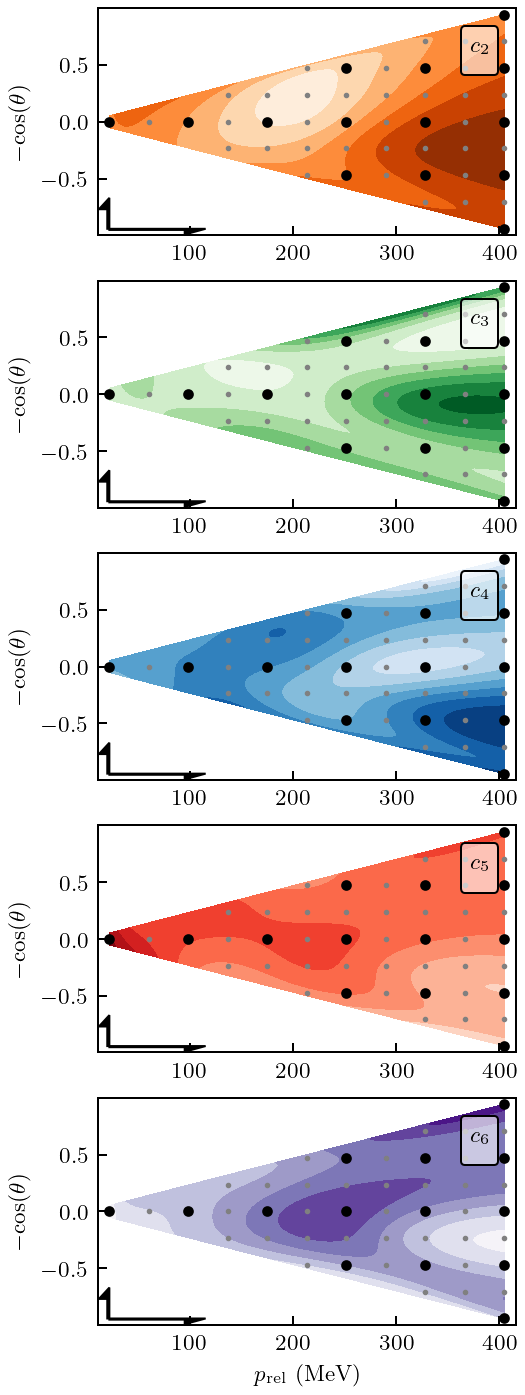

In [13]:
# plots 2D coefficients
My2DPlot.plot_coefficients(whether_save=False)

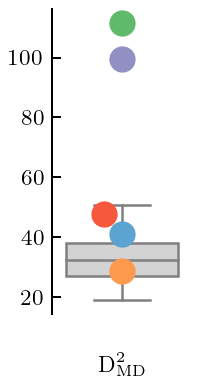

In [14]:
# plots Mahalanobis distance (squared)
My2DPlot.plot_md(whether_save=False)

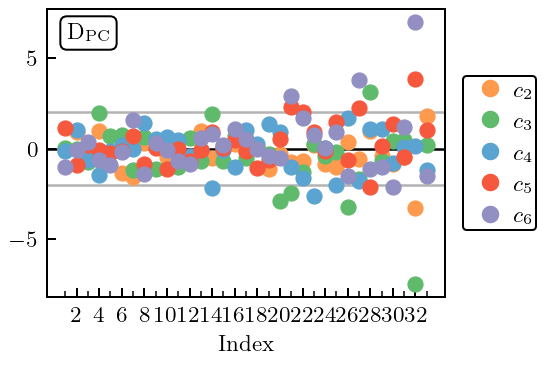

In [15]:
# plots pivoted Cholesky decomposition
My2DPlot.plot_pc(whether_save=False)

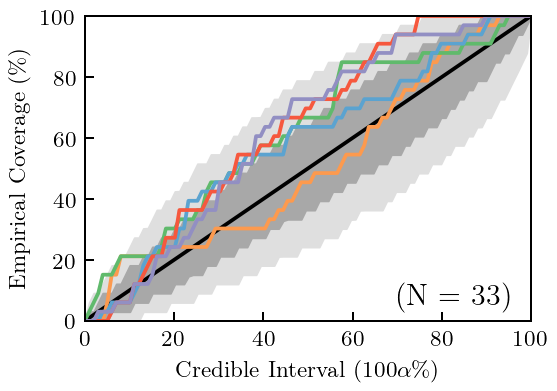

In [16]:
# plots credible intervals (a/k/a weather plot)
My2DPlot.plot_credible_intervals(whether_save=False)

## Part 2: Nonstationarity in toy data
This section of the notebook deals with exploring nonstationarity in toy (i.e., synthetic) data.

In [17]:
# length-scale scaling function for synthetic data
def scaling_fn_toy(X,
               ls_array = np.array([1]),
               exponent = 0):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    ls = np.array([])
    
    for pt_idx, pt in enumerate(X):
#         ls = np.append(ls, ls_array)
        ls = np.append(ls, np.array([ls_array[0], ls_array[1] * X[pt_idx, 0]**(-1. * exponent)
                                     ]))

    ls = np.reshape(ls, X_shape)

    return ls

scaling_fn_toy_kwargs={}

# cbar^2 (i.e., variance) scaling function for synthetic data
def cbar_fn_toy(X,
               cbar_array = np.array([1]),
               scaling = 1,
               offset = 0.5):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    cbar = np.array([])

    for pt_idx, pt in enumerate(X):
#         cbar = np.append(cbar, cbar_array)
        R = np.max(X[:, 0]) - np.min(X[:, 0])
        cbar = np.append(cbar, np.array([(1 + (scaling / R * (pt[0] - offset * R)) ** (2)) ** (-0.5)
                                         ]))
    cbar = np.reshape(cbar, X_shape[:-1])

    return cbar

cbar_fn_toy_kwargs={"scaling" : 4.8,
                "offset" : 0.63}

In [18]:
n_orders = 6    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 20  # We are going to treat some high order result as the final, converged answer
orders_array = np.arange(0, n_orders, 1, dtype = int)
orders_all_array = np.arange(0, final_order + 1, 1, dtype = int)

t_lab = np.linspace(1, 351, 51)
degrees = np.linspace(1, 179, 49)

E_lab = t_lab
angle_lab = degrees
E_angle_pair = [E_lab, angle_lab]

# The true values of the hyperparameters for generating the EFT coefficients
ls_E = 100
ls_deg = 45
ls_deg_mag = 900
ls_deg_exp = 0.5
scaling_fn_toy_kwargs.update({"exponent" : ls_deg_exp})
sd_gp = 1.0
sd_fixed = None
center = 0
ref = 1
nugget = 1e-10
df = 3
disp = 0
scale = 1.0
seed = 118

# sets 2D momentum mesh
p_toy = p_approx("pprel", E_to_p(t_lab, interaction = "np"), degrees).T
print(np.shape(p_toy))
print(p_toy)
Q_param_toy = "sum"
p_param_toy = "pprel"
mpi_toy = 96
Lambda_b_toy = 431
# if Q is constant, use next line
# ratio = 0.3
# if Q is not constant, use next line
Q_toy = Q_approx(p_toy, "sum", Lambda_b = Lambda_b_toy, m_pi = mpi_toy,
             single_expansion=False)

# sets kernels
# kernel_toy = RBF(length_scale=(ls_E, ls_deg),
#                length_scale_bounds=((ls_E / 4, ls_E * 4),
#                                     (ls_deg / 4, ls_deg * 4))) + \
#            WhiteKernel(1e-6, noise_level_bounds='fixed')
kernel_toy = NSRBF(length_scale=(ls_E, ls_deg_mag),
               length_scale_bounds=((ls_E / 4, ls_E * 4),
                                    (ls_deg_mag / 4, ls_deg_mag * 4)), 
                  length_scale_fixed = True, 
                  length_scale_fn=scaling_fn_toy,
                length_scale_fn_kwargs=scaling_fn_toy_kwargs,

                cbar=(1),
                cbar_bounds=((0.01, 10)),
                cbar_fixed=True,
                cbar_fn=cbar_fn_toy,
                cbar_fn_kwargs=cbar_fn_toy_kwargs,) + \
           NSWhiteKernel(1e-6, noise_level_bounds='fixed')

# creates Gaussian processes
gp_toy = gm.ConjugateGaussianProcess(kernel = kernel_toy, 
                        center = center, df = df, disp = disp, 
                        scale = scale, nugget = 1e-10, sd = sd_fixed)
# generates coefficients randomly up to final_order
coeffs_toy = np.swapaxes(np.reshape(- gp_toy.sample_y(np.array(list(itertools.product(t_lab, degrees))), 
                         n_samples = n_orders, 
                         random_state = seed), (len(t_lab), len(degrees), n_orders)).T, 1, 2)

(51, 49)
[[ 21.65954334  21.65954334  21.65954334 ...  21.65954334  21.65954334
   21.65954334]
 [ 61.26243994  61.26243994  61.26243994 ...  61.26243994  61.26243994
   61.26243994]
 [ 83.88705078  83.88705078  83.88705078 ...  83.88705078  83.88705078
   83.88705078]
 ...
 [397.61637528 397.61637528 397.61637528 ... 397.61637528 397.61637528
  397.61637528]
 [401.72469809 401.72469809 401.72469809 ... 401.72469809 401.72469809
  401.72469809]
 [405.79142946 405.79142946 405.79142946 ... 405.79142946 405.79142946
  405.79142946]]


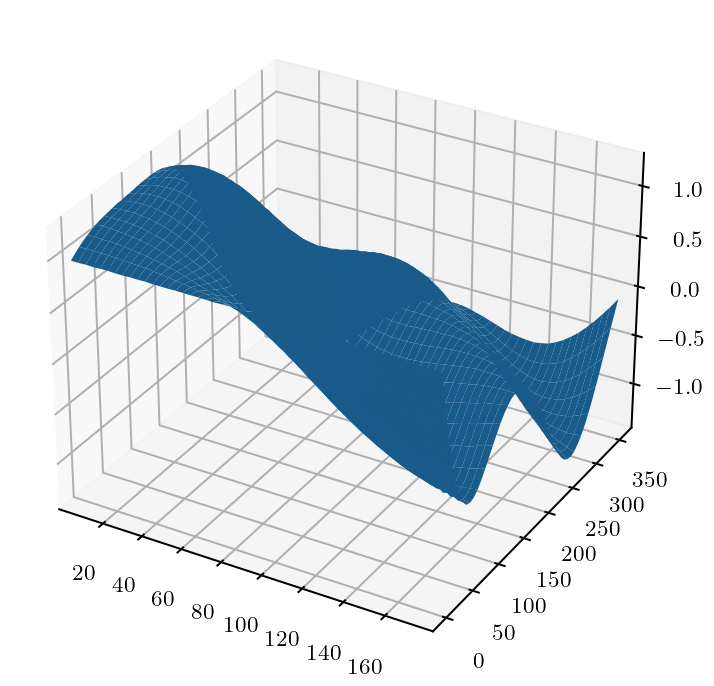

In [19]:
# plots coefficients at an order
fig = plt.figure()
ax = plt.axes(projection="3d")
(XA, XB) = np.meshgrid(degrees, t_lab)
ax.plot_surface(XA, XB, coeffs_toy[0, :, :])

In [20]:
# generates data using coefficients and other EFT parameters (e.g., dimensionless expansion parameter)
data_toy = gm.partials(
    coeffs = np.reshape(coeffs_toy, (n_orders, len(t_lab) * len(degrees))).T, 
    # if Q is not constant, use next line
    ratio = np.reshape(Q_toy, (len(t_lab) * len(degrees))), 
    # if Q is constant, use next line
#     ratio = ratio,
    ref = ref, 
    orders = orders_array)

data_toy = np.reshape(data_toy.T, (n_orders, len(t_lab), len(degrees)))

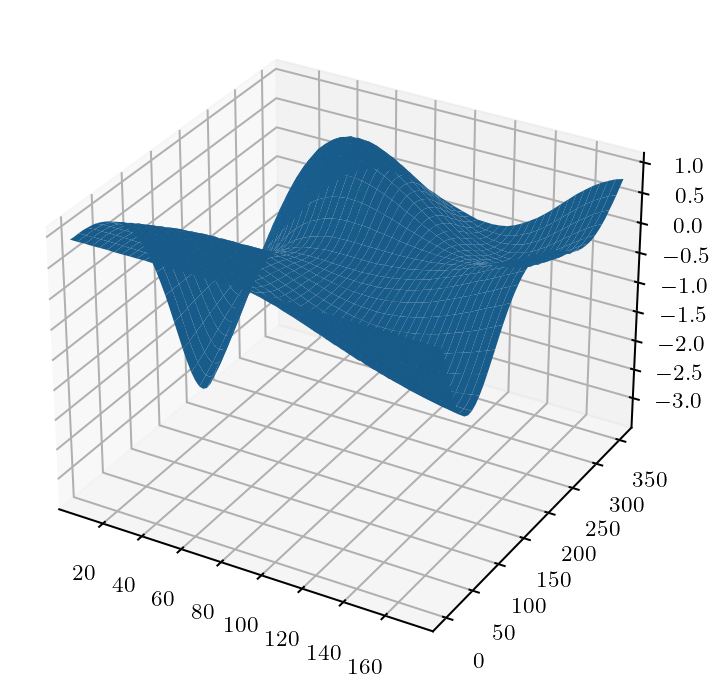

In [21]:
# plots data at an order
fig = plt.figure()
ax = plt.axes(projection="3d")
(XA, XB) = np.meshgrid(degrees, t_lab)
ax.plot_surface(XA, XB, data_toy[3, :, :])

In [22]:
# sets the potential under test
ScaleSchemeToy = ScaleSchemeBunch(
    "",
    np.array([0, 1, 2, 3, 4, 5,]),
    ["Oranges", "Greens", "Blues", "Reds", "Purples"],
    "Toy",
    "Data",
)

# sets the observable under test
OBSToy = ObservableBunch(
            "OBS",
            data_toy,
            E_angle_pair,
            "Obs.",
            "dimensionless",
            nn_interaction = "np",
            unit_string="",
        )
ObservableToy = OBSToy

In [23]:
# sets the "x_E" input space
ElabBunch = InputSpaceBunch(
                    "Elab",
                    Elab_fn,
                    p_approx(
                        "Qofprel",
                        E_to_p(t_lab, interaction="np"),
                        degrees,
                    ),
                    r"$E_{\mathrm{lab}}$ (MeV)",
                    [r"$", ObservableToy.title, r"(E_{\mathrm{lab}}, \theta= ", 0, "^{\circ})$"],
                )

# sets the "x_theta" input space
DegBunch = InputSpaceBunch(
                    "deg",
                    deg_fn,
                    p_approx(
                        "pprel",
                        E_to_p(t_lab, interaction="np"),
                        degrees,
                    ),
                    r"$\theta$ (deg)",
                    [
                        r"$",
                        ObservableToy.title,
                        r"(\theta, E_{\mathrm{lab}}= ",
                        0,
                        "\,\mathrm{MeV})$",
                    ],
                )

# sets the full 2D input space
vsquantity_array_toy = [ElabBunch, DegBunch]
for vsq in vsquantity_array_toy:
    try:
        vsq.make_title()
    except:
        pass

In [24]:
# sets (x_E, x_theta) length scale objects for fitting
ls_array_toy = [LengthScale("1/16-1_fitted", 2/7, 0.25, 4, whether_fit=True), 
            LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)]

# makes initial guesses for the length scales
for (ls, vsq) in zip(ls_array_toy, vsquantity_array_toy):
    ls.make_guess(
            vsq.input_space(
                **{
                    "deg_input": angle_lab,
                    "p_input": E_to_p(
                            E_lab, interaction="np"
                        ),
                    "E_lab": E_lab,
                    "interaction": "np",
                }
            )
        )
#     print(np.shape(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             )))
#     print(vsq.input_space(
#                 **{
#                     "deg_input": angle_lab,
#                     "p_input": E_to_p(
#                             E_lab, interaction="np"
#                         ),
#                     "E_lab": E_lab,
#                     "interaction": "np",
#                 }
#             ))
#     print(ls.ls_guess)

# sets (2D) dimensionless expansion parameter Q
ratio_toy = Q_approx(
            p_approx("pprel", E_to_p(E_lab, "np"), angle_lab),
            "sum",
            Lambda_b=431,
            m_pi=96,
        ).T

# sets initial guesses for GP hyperparameters
GPHyperToy = GPHyperparameters(
            ls_array_toy,
            center = 0,
            ratio = ratio_toy,
            df=1,
            disp=0,
            scale=1,
            seed=None,
            sd=None,
        )

In [25]:
# information on orders
OrdersToy = OrderInfo(
            ScaleSchemeToy.orders_full,
            [0] + [],
            ScaleSchemeToy.colors,
            ScaleSchemeToy.light_colors,
            orders_names_dict=None,
            orders_labels_dict=None,
        )

In [26]:
# sets file-naming convention
FileNameToy = FileNaming(
                "sum",
                "pprel",
                filename_addendum="",
            )

In [27]:
# sets base (x_E, x_theta) input spaces
x_quantity = [["energy", E_lab, t_lab, "MeV"], ["angle", angle_lab, degrees, "degrees"]]

In [28]:
# sets train/test split
TTS = TrainTestSplit("nicegrid", [4, 4], [3, 3], 
           xmin_train_factor = [0, 0], 
           xmax_train_factor = [1, 1])

In [29]:
# creates GSUM objects necessary to generate statistical diagnostics
Toy2D = GSUMsandbox(
                    schemescale = ScaleSchemeToy,
                    observable = ObservableToy, 
                    inputspace = vsquantity_array_toy, 
                    traintestsplit = TTS,
                    gphyperparameters = GPHyperToy, 
                    orderinfo = OrdersToy, 
                    filenaming = FileNameToy,
                    x_quantity=x_quantity,
    
                    warping_fn = None,
                    warping_fn_kwargs = {},
                    length_scale_list=[NSKernelParam(60, [10, 200]),
                        NSKernelParam(1000, [100, 10000])],
#                         NSKernelParam(50, [5, 200])],
                    length_scale_fixed=False,
                    cbar_list=[NSKernelParam(1.0, [0.1, 10])],
                    cbar_fixed=True,
                    scaling_fn = scaling_fn_toy,
                    scaling_fn_kwargs = scaling_fn_toy_kwargs,
                    cbar_fn = cbar_fn_toy,
                    cbar_fn_kwargs = cbar_fn_toy_kwargs,
)

self.x_train = [[  1.    1. ]
 [  1.   45.5]
 [  1.   90. ]
 [  1.  134.5]
 [  1.  179. ]
 [ 88.5   1. ]
 [ 88.5  45.5]
 [ 88.5  90. ]
 [ 88.5 134.5]
 [ 88.5 179. ]
 [176.    1. ]
 [176.   45.5]
 [176.   90. ]
 [176.  134.5]
 [176.  179. ]
 [263.5   1. ]
 [263.5  45.5]
 [263.5  90. ]
 [263.5 134.5]
 [263.5 179. ]
 [351.    1. ]
 [351.   45.5]
 [351.   90. ]
 [351.  134.5]
 [351.  179. ]]
self.coeffs_train = [[-0.53310226  0.30000612 -0.05526419  0.4703755  -0.60702862]
 [-0.52896785  0.30973167  0.01749347  0.44311568 -0.59109543]
 [-0.52743066  0.31842686  0.0925533   0.41812261 -0.56685616]
 [-0.52219138  0.31985712  0.16445041  0.39004954 -0.54041592]
 [-0.51646946  0.32371582  0.23614362  0.36012466 -0.51462256]
 [-1.23404409  0.44891287 -0.94372295  0.45892072 -0.62573706]
 [-0.85675182  0.34581012 -0.24072516  0.34894548  0.14093503]
 [-0.51122651  0.15067877  0.32415319 -0.12217554  0.76468517]
 [-0.29130623  0.16062558  0.59526    -0.56945643  0.9015895 ]
 [-0.15568914  0.54706

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([20.85911335, 48.83255132]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.82357562, 63.40912062]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  25.53973035, -340.8051004 ]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
 

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([13.81395458, 57.52311248]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 97, 'nit': 8, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.10481764, 65.55604341]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 2, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

self.ls_true = [ 93.45185002 849.20729657]
self.underlying_std = 1.4680158275815378
5


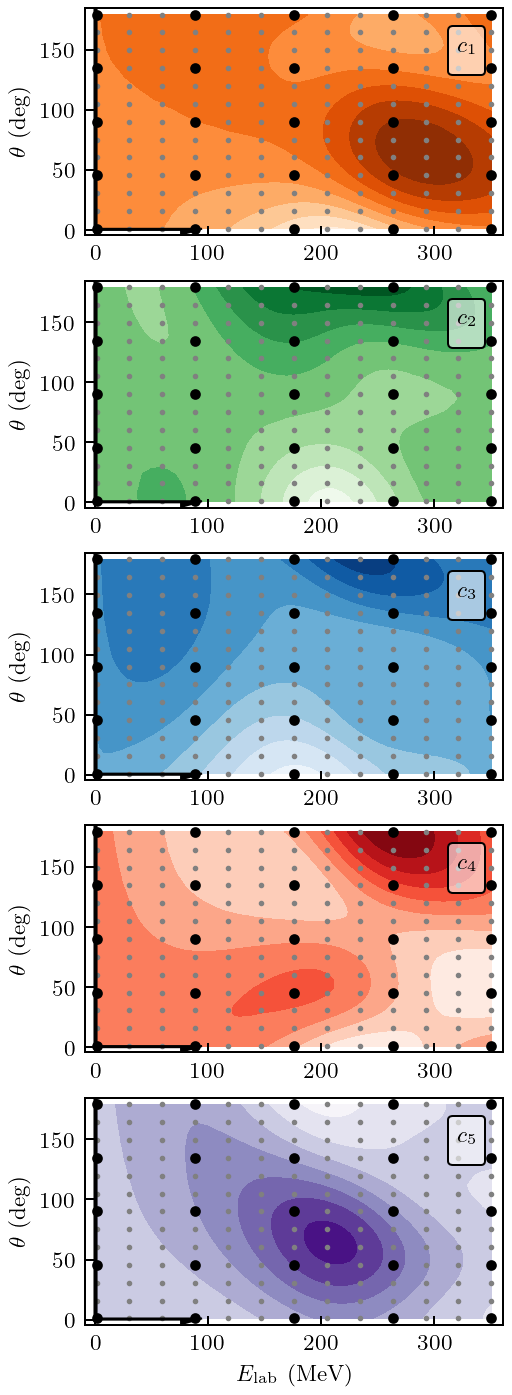

In [30]:
# plots 2D coefficients
Toy2D.plot_coefficients(whether_save=False)

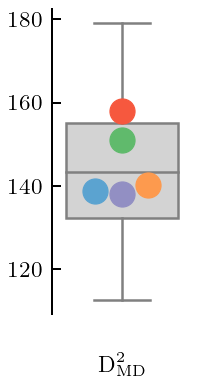

In [31]:
# plots Mahalanobis distance (squared)
Toy2D.plot_md(whether_save=False)

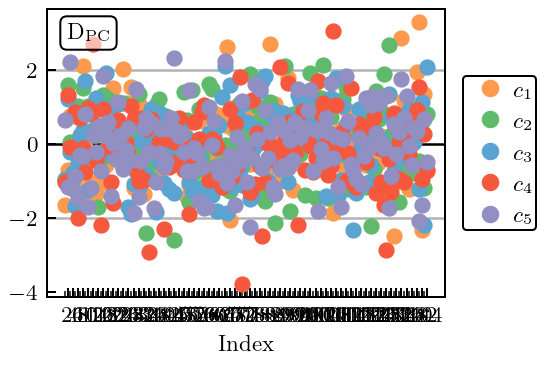

In [32]:
# plots pivoted Cholesky decomposition
Toy2D.plot_pc(whether_save=False)

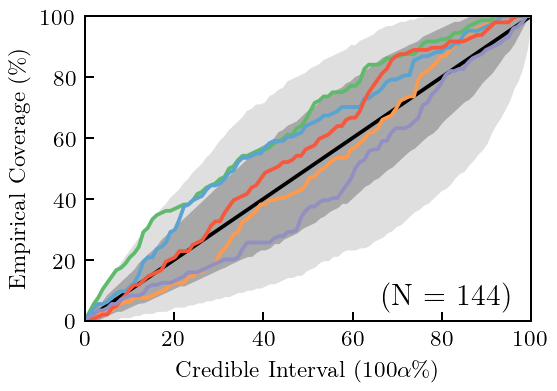

In [33]:
# plots credible intervals (a/k/a weather plots)
Toy2D.plot_credible_intervals(whether_save=False)